# Participants’ agreement

- use Gwet AC1 (2014) to measure inter-participants’ agreement
- the experiment is interpreted as an annotation task where participants (coders) annotate each triplets using single characters as labels
- to study within-participant agreement, use response entropy across participants

In [42]:
# intro, defaults (shared across notebooks)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
from irrCAC.raw import CAC

# ---------------------------------------------------
# set global properties for plotting

font = {"family":"Adapter Mono PE", "size":"10", "weight":"medium"}
figure = {"titlesize":"10","titleweight":"medium"}
axes = {"titlesize":"10", "titleweight":"medium", "labelsize":"10", "labelweight":"medium"}
plt.rc("font", **font)
plt.rc("figure", **figure)
plt.rc("axes", **axes)
COL = "black"
box_colors = dict(boxes=COL, whiskers=COL, medians=COL, caps=COL)

# ---------------------------------------------------
# Fisher’s Exact test via R

from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
# activate the Pandas conversion of rpy2
pandas2ri.activate()
# import stats package
rstats = importr("stats")

def fisher_exact(counts, cols=["T1", "T2"]):
    """
    (Using R via rpy2. See the imports above.)
    
    Performs Fisher’s exact test for testing the null of independence
    of rows and columns in a contingency table with fixed marginals.
    
    Input:  df - DataFrame 2x3
    Output: pval - p-value of the test
    """

    def scale(counts, total):
        """
        Scale the counts to fit the total provided.
        Avoid rounding errors.
        """
        
        counts = counts / counts.sum() * total
        counts = counts.round()
        counts.iloc[2] = total - (counts.iloc[0] + counts.iloc[1])
        return counts

    # scale counts with the smaller total to the larger total
    counts_ = counts.copy()
    total1 = counts_[cols[0]].sum()
    total2 = counts_[cols[1]].sum()
    if total1 < total2:
        counts_[cols[0]] = scale(counts_[cols[0]], total2)
    elif total1 > total2:
        counts_[cols[1]] = scale(counts_[cols[1]], total1)
    
    # perform Fisher’s test
    res = rstats.fisher_test(counts)
    # return p-value
    return res.rx("p.value")[0][0]

In [43]:
# Get data & fix types

# Tall data (a single response per row)
data = pd.read_csv("csv/raw-data-preprocessed_tall.csv", index_col=0, header=0, dtype="unicode")
data.sort_index(axis=1, inplace=True)
data["pid"] = data["pid"].astype("int")
data["order"] = data["order"].astype("float").astype("int")
#data["response"] = data["response"].astype("category")
data["fluent in script"] = (data["fluent in script"] == "True").astype("category")
data["native in script"] = (data["native in script"] == "True").astype("category")

# Wide data (all participant responses per row, lots of NA)
data_wide = pd.read_csv("csv/raw-data-preprocessed.csv", index_col=0, header=[0,1,2], dtype="unicode")
data_wide.sort_index(axis=1, inplace=True)
data_wide[("control", "control", "order")] = data_wide[("control", "control", "order")].astype("float").astype("int")
data_wide[("control", "control", "fluent in script")] = (data_wide[("control", "control", "fluent in script")] == "True").astype("category")
data_wide[("control", "control", "native in script")] = (data_wide[("control", "control", "native in script")] == "True").astype("category")

SCRIPTS = ["cyrillic", "devanagari", "latin"]
DESIGNERS = ["Graphic designer", "Typographer", "Other designer"]
TYPEFACES = {script: sorted(data[data["script"] == script]["typeface"].drop_duplicates().values) for script in SCRIPTS}
CHARS = sorted(data["response"].drop_duplicates().values)

In [44]:
#display(data)
pcount = len(data[data["order"] == 1]) // 56
scount = len(data) // 56
print(f"Tall: imported {data.shape[0]} rows, {data.shape[1]} columns, {pcount} participants, {scount} sessions, 56 trial responses each.")

Tall: imported 100072 rows, 14 columns, 1721 participants, 1787 sessions, 56 trial responses each.


In [45]:
from collections import Counter
import scipy.stats as st
import statsmodels.stats.api as sms

def get_entropy(responses):
    counts = Counter(responses)
    probs = [c / sum(counts.values()) for c in counts.values()]
    return st.entropy(probs, base=2)

def get_mean_ci(data, alpha=0.95):
    return sms.DescrStatsW(data).tconfint_mean(alpha=alpha)

# Compute entropy for each participant
# Use data only from the first session
edata = data[data["order"] == 1].groupby("pid")["response"].apply(get_entropy).reset_index()
edata.columns = ["pid", "entropy"]
# Merge entropy with participants’ data
demographic_data = data.drop_duplicates(subset=["pid"])
edata = pd.merge(edata, demographic_data, on="pid")

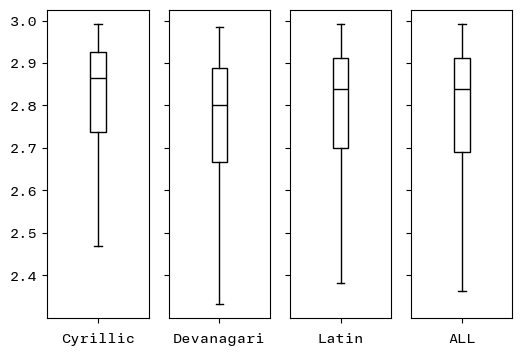

In [46]:
# Entropy per script (box plots)

# report & plot multiple box plots next to each other
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0.2, hspace=0)

for i, script in enumerate(SCRIPTS+["ALL"]):
  if script == "ALL":
    entropy_values = edata["entropy"]
  else:
    entropy_values = edata[edata["script"] == script]["entropy"]
    script = script.title()
  entropy_values.name = ""
  entropy_values.plot(kind="box",
                      patch_artist=True,
                      showfliers=False,
                      boxprops=dict(facecolor="white", color=COL),
                      color=box_colors,
                      xlabel=script,
                      title="",
                      ax=axes[i],
                      )
fig.savefig("graphics/entropy_box-plots.pdf", bbox_inches="tight")

In [47]:
# Participant agreement per script and typeface

# per typeface
COLS = ["Typeface", "Gwet", "Entropy"]
for script in SCRIPTS:
  print(script.title())
  results = pd.DataFrame(columns=COLS)
  for typeface in TYPEFACES[script]:
    # taking both order=1 and order=2
    adata = pd.DataFrame(data_wide[(script, typeface,)].dropna(how="all"))
    for c in adata.columns:
      adata[c] = [np.nan if pd.isnull(v) else CHARS.index(v) for v in adata[c].values]
    raters = CAC(adata.T)
    gwet = raters.gwet()["est"]["confidence_interval"]
    # considered only order=1
    entropy = edata[(edata["script"] == script) & (edata["typeface"] == typeface)]["entropy"]
    entropy_ci = get_mean_ci(entropy)
    results.loc[len(results), COLS] = [
      typeface,
      f"({gwet[0]:.2f}, {gwet[1]:.2f})",
      f"({entropy_ci[0]:.3f}, {entropy_ci[1]:.3f})"
      ]
  display(results)
  results.to_csv(f"csv/agreement_per-typeface_{script}.csv")
  
# overall results per script
COLS = ["Script", "Gwet", "Entropy"]
results = pd.DataFrame(columns=COLS)
for script in SCRIPTS:
  adata = pd.DataFrame(data_wide[(script,)].dropna(how="all"))
  for c in adata.columns:
    # taking both order=1 and order=2
    adata[c] = [np.nan if pd.isnull(v) else CHARS.index(v) for v in adata[c].values]
  raters = CAC(adata.T)
  gwet = raters.gwet()["est"]["confidence_interval"]
  # considered only order=1
  entropy = edata[edata["script"] == script]["entropy"]
  entropy_ci = get_mean_ci(entropy)
  results.loc[len(results), COLS] = [
    script.title(),
    f"({gwet[0]:.2f}, {gwet[1]:.2f})",
    f"({entropy_ci[0]:.3f}, {entropy_ci[1]:.3f})"
    ]
display(results)
results.to_csv(f"csv/agreement_per-script.csv")

Cyrillic


,Typeface,Gwet,Entropy
0,arial,"(0.43, 0.52)","(2.843, 2.845)"
1,century-schoolbook,"(0.47, 0.56)","(2.801, 2.803)"
2,courier-new,"(0.46, 0.56)","(2.813, 2.816)"
3,georgia,"(0.47, 0.57)","(2.814, 2.817)"
4,pt-sans,"(0.55, 0.66)","(2.801, 2.803)"
5,pt-serif,"(0.42, 0.50)","(2.864, 2.866)"
6,times-new-roman,"(0.48, 0.59)","(2.852, 2.854)"
7,verdana,"(0.42, 0.50)","(2.650, 2.653)"


Devanagari


,Typeface,Gwet,Entropy
0,adobe-devanagari,"(0.33, 0.40)","(2.750, 2.752)"
1,devanagari-mt,"(0.37, 0.43)","(2.765, 2.768)"
2,ek-mukta,"(0.39, 0.48)","(2.656, 2.660)"
3,itf-devanagari,"(0.39, 0.47)","(2.710, 2.713)"
4,kohinoor-devanagari,"(0.46, 0.56)","(2.876, 2.878)"
5,lohit-devanagari,"(0.38, 0.45)","(2.708, 2.710)"
6,murty-hindi,"(0.39, 0.46)","(2.809, 2.811)"
7,nirmala-ui,"(0.37, 0.45)","(2.794, 2.797)"


Latin


,Typeface,Gwet,Entropy
0,arial,"(0.46, 0.57)","(2.814, 2.816)"
1,calibri,"(0.50, 0.63)","(2.817, 2.819)"
2,cambria,"(0.50, 0.64)","(2.706, 2.709)"
3,candara,"(0.50, 0.63)","(2.878, 2.879)"
4,century-schoolbook,"(0.49, 0.61)","(2.808, 2.810)"
5,courier-new,"(0.52, 0.64)","(2.877, 2.878)"
6,futura,"(0.54, 0.66)","(2.768, 2.770)"
7,georgia,"(0.51, 0.62)","(2.851, 2.853)"
8,pt-sans,"(0.49, 0.61)","(2.689, 2.692)"
9,pt-serif,"(0.46, 0.58)","(2.690, 2.693)"


,Script,Gwet,Entropy
0,Cyrillic,"(0.54, 0.57)","(2.807, 2.808)"
1,Devanagari,"(0.47, 0.49)","(2.756, 2.757)"
2,Latin,"(0.58, 0.61)","(2.785, 2.786)"


In [48]:
# Check if the distribution of entropy is non-normal -> cannot use ANOVA or t-test

display(pg.normality(edata, group="design skills", dv="entropy"))
display(pg.normality(edata, group="native in script", dv="entropy"))
display(pg.normality(edata, group="fluent in script", dv="entropy"))

,W,pval,normal
design skills,,,
Letter designer,0.876872,3.684023e-09,False
Non-designer,0.881298,3.430038e-28,False
Other designer,0.897060,9.872380e-09,False
Graphic designer,0.898404,2.952937e-12,False
Typographer,0.876319,2.312871e-06,False


,W,pval,normal
native in script,,,
True,0.874839,7.753630e-33,False
False,0.934986,5.885089e-09,False


,W,pval,normal
fluent in script,,,
True,0.879935,1.329728e-33,False
False,0.941602,1.654876e-04,False


In [49]:
# Describe individual groups

MIN_RESPONSE_TOTAL = 8  # minimal total response count (checked per group)
MIN_TRIALS = 8  # minimal number of shared trials, has to be bigger than 2 for the sake of correlation tests
COLS = [  # to get a nice order in the result reports
  "Script",
  "Group",
  "Groups compared",
  "Participants",
  "Trials",
  "Agreement",
  "Effect",
  "Spearman",
  "Spearman (p)",
  "Gwet",
  "Freq. (p)",
  "Entropy",
  "Entropy (p)",
  "Entropy (result)",
  "Response total (mean)",
]

def subset_data(data, groupby, values, script, wide=False):
  """
  Apply conditions to subset the main data
  """

  # wide data use different column index
  if wide:
    GROUPBY = ("control", "control", groupby)
    ORDER = ("control", "control", "order")
    SCRIPT = ("control", "control", "script")
  else:
    GROUPBY = groupby
    ORDER = "order"
    SCRIPT = "script"

  # for background/demography-based analysis, using only order=1
  condition = (data[SCRIPT] == script) & (data[ORDER] == 1)
  for i, v in enumerate(values):
    if isinstance(v, (list, tuple)):
      yield data[condition & (data[GROUPBY].isin(v))]
    else:
      yield data[condition & (data[GROUPBY] == v)]

results = []
for script in SCRIPTS:
  # get data for different groups
  for groupby, value in [
    ("fluent in script", True),
    ("fluent in script", False),
    ("native in script", True),
    ("native in script", False),
    ("design skills", "Non-designer"),
    ("design skills", DESIGNERS),
    ("design skills", "Letter designer"),
  ]:
    row_results = {}
    # subset the wide dataset
    adata = pd.DataFrame(*subset_data(data_wide, groupby, [value], script, wide=True))
    # filter out unnecessary columns, incl. control
    adata = adata[script].dropna(how="all")

    if len(adata.columns) > MIN_TRIALS and len(adata.index) > MIN_RESPONSE_TOTAL:
    
      # Mean total response count across both groups
      total_mean = adata.count().mean()

      # Gwet AC1
      # format the reliability data
      for c in adata.columns:
        adata[c] = [np.nan if pd.isnull(v) else CHARS.index(v) for v in adata[c].values]
      raters = CAC(adata.T)
      gwet = raters.gwet()["est"]["confidence_interval"]

      # Entropy
      entropy = pd.DataFrame(*subset_data(edata, groupby, [value], script))["entropy"]
      entropy_ci = get_mean_ci(entropy)
      row_results = {
        "Response total (mean)": f"{total_mean:.1f}",
        "Gwet":  f"({gwet[0]:.2f}, {gwet[1]:.2f})",
        "Entropy": f"({entropy_ci[0]:.3f}, {entropy_ci[1]:.3f})",
      }
    # format results
    if groupby.startswith("fluent"):
      group_nice = "Fluent" if value else "Non-fluent"
    elif groupby.startswith("native"):
      group_nice = "Native" if value else "Non-native"
    elif groupby.startswith("design"):
      if value == DESIGNERS:
        group_nice = "Designers"
      else:
        group_nice = f"{value}s"
    
    row_results["Script"] = script.title()
    row_results["Group"] = group_nice
    row_results["Participants"] = f"{len(adata)}"

    results.append(pd.Series(row_results, index=COLS))
results = pd.concat(results, axis=1).dropna(how="all").fillna("—")
display(results.T)
results.T.to_csv("csv/agreement_groups-separately.csv")

/Users/davidbrezina/.pyenv/versions/data/lib/python3.11/site-packages/irrCAC/raw.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ratings.replace(to_replace="", value=np.nan, inplace=True)
/Users/davidbrezina/.pyenv/versions/data/lib/python3.11/site-packages/irrCAC/raw.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ratings.replace(to_replace="", value=np.nan, inplace=True)


,Script,Group,Participants,Gwet,Entropy,Response total (mean)
0,Cyrillic,Fluent,482,"(0.54, 0.57)","(2.808, 2.809)",60.2
1,Cyrillic,Non-fluent,27,"(0.56, 0.64)","(2.773, 2.776)",3.4
2,Cyrillic,Native,472,"(0.54, 0.57)","(2.807, 2.808)",59.0
3,Cyrillic,Non-native,37,"(0.55, 0.61)","(2.799, 2.802)",4.6
4,Cyrillic,Non-designers,361,"(0.54, 0.57)","(2.818, 2.819)",45.1
5,Cyrillic,Designers,121,"(0.56, 0.60)","(2.776, 2.778)",15.1
6,Cyrillic,Letter designers,27,"(0.51, 0.58)","(2.792, 2.796)",3.4
7,Devanagari,Fluent,356,"(0.46, 0.48)","(2.754, 2.756)",44.5
8,Devanagari,Non-fluent,76,"(0.50, 0.54)","(2.765, 2.767)",9.5
9,Devanagari,Native,259,"(0.45, 0.48)","(2.757, 2.758)",32.4


In [50]:
# Compare between groups with hypothesis tests

from scipy.stats import mannwhitneyu

results = []
for script in SCRIPTS:
  hypothesis_counter = 0
  # get data for different groups
  for groupby, values in [
    ("fluent in script", (True, False)),
    ("native in script", (True, False)),
    ("design skills", ("Non-designer", DESIGNERS)),
    ("design skills", ("Letter designer", DESIGNERS)),
    ("design skills", ("Non-designer", "Letter designer")),
  ]:    
    row_results = {}
    # subset the tall dataset
    data1, data2 = subset_data(data, groupby, values, script)
    
    # aggregate responses to get response counts
    counts = pd.DataFrame(data1.groupby(["typeface", "triplet"])["response"].value_counts())
    counts2 = pd.DataFrame(data2.groupby(["typeface", "triplet"])["response"].value_counts())
    # combine counts from both groups into a single data frame
    counts = counts.join(counts2, how="outer", lsuffix="1", rsuffix="2", validate="one_to_one")

    # remove trials with insufficient total responses
    # get a list of all unique (typeface, triplet) combinations
    ttriplets = counts.droplevel(level="response").index.unique()
    totals = []
    for ttriplet in ttriplets:
      for s in counts.loc[ttriplet, :].sum(axis=0).values:
        if s < MIN_RESPONSE_TOTAL:
          # delete all existing responses
          for c in eval(ttriplet[1]):
            i = tuple(list(ttriplet) + [c])
            if i in counts.index:
              counts.drop(i, inplace=True)
        else:
          totals.append(s)

    # to be safe, get the list of triplets again, without dropped trials
    ttriplets = counts.droplevel(level="response").index.unique()
    if len(ttriplets) > MIN_TRIALS:
      # Mean total response count across both groups
      total_mean = pd.Series(totals).mean()

      # OOOO agreementand
      # Fisher’s Exact test for effect on triplet counts
      agreement = 0
      effect = 0
      alpha_cor = 0.013
      freqs = pd.DataFrame(columns=counts.columns, index=ttriplets)
      for ttriplet in ttriplets:
          oooo = counts.loc[ttriplet, :].idxmax().values
          if oooo[0] == oooo[1]:
            freqs.loc[ttriplet, :] = counts.loc[ttriplet, :].max() / counts.loc[ttriplet, :].sum()
            agreement += 1
          # Fisher’s Exact test for effect on triplet counts
          tcounts = counts.loc[ttriplet, :].copy()
          # correct missing values
          if len(tcounts) < 3:
            for c in eval(ttriplet[1]):
              if c not in tcounts.index:
                tcounts.loc[c, :] = 0
          effect_p = fisher_exact(tcounts.fillna(0).astype(int), cols=["count1", "count2"])
          if effect_p < alpha_cor:
            effect += 1

      # OOOO frequencies MWU hypothesis test
      # Using the non-parametric Mann Whitney U test as entropy has a non-normal distribution.
      # If the p-value is <0.05, reject the null hypothesis that there is no difference between the distributions
      freqs = freqs.astype(np.float32)
      freqs.dropna(how="all", inplace=True)
      oooo_u, oooo_p = mannwhitneyu(freqs["count1"], freqs["count2"], alternative="two-sided")
      hypothesis_counter += 1

      # Spearman’s rank correlation test
      # includes r, p-unc, CI95% (confidence intervals), power
      # If the p-value is <0.05, reject the null of no correlation
      spearman = pg.pairwise_corr(counts, columns=["count1", "count2"], method="spearman")
      spearman_r = spearman["r"].iloc[0]
      spearman_p = spearman["p-unc"].iloc[0]

      # Entropy MWU hypothesis test
      # Using the non-parametric Mann Whitney U test as entropy has a non-normal distribution.
      # If the p-value is <0.05, reject the null hypothesis that there is no difference between the distributions
      edata1, edata2 = subset_data(edata, groupby, values, script)
      entropy_u, entropy_p = mannwhitneyu(edata1["entropy"], edata2["entropy"], alternative="two-sided")

      row_results = {
        "Response total (mean)": f"{total_mean:.1f}",
        "Agreement":  f"{100 * agreement / len(ttriplets):.1f} %",
        "Effect":  f"{100 * effect / len(ttriplets):.1f} %",
        "Spearman":  f"{spearman_r:.2f}",
        "Spearman (p)":  f"{spearman_p:.3f}",
        "Freq. (p)":  f"{oooo_p:.3f}",
        "Entropy (p)": f"{entropy_p:.3f}",
      }
    # format results
    if groupby.startswith("fluent"):
      groups_nice = "Fluent vs. Non-fluent"
    elif groupby.startswith("native"):
      groups_nice = "Native vs. Non-native"
    elif groupby.startswith("design"):
      names = [v if isinstance(v, str) else "Designers" for v in values]
      groups_nice = f"{names[0]}s vs. {names[1]}"
    
    row_results["Script"] = script.title()
    row_results["Groups compared"] = groups_nice
    row_results["Trials"] = f"{len(ttriplets)}"

    # Entropy: reject null hypothesis?
    # if "Entropy (p)" in row_results:
    #   # alpha after Bonferroni correction
    #   alpha = 0.05 / hypothesis_counter
    #   row_results["Entropy (result)"] = "reject null" if entropy_p < alpha else "nothing"
    results.append(pd.Series(row_results, index=COLS))
results = pd.concat(results, axis=1).dropna(how="all").fillna("—")
display(results.T)
results.T.to_csv("csv/agreement_groups-compared.csv")

# alpha after Bonferroni correction
alpha_cor = 0.05 / hypothesis_counter
print(f"Alpha is {alpha_cor:.3f} after Bonferroni correction for a family of {hypothesis_counter} hypotheses.")

,Script,Groups compared,Trials,Agreement,Effect,Spearman,Spearman (p),Freq. (p),Entropy (p),Response total (mean)
0,Cyrillic,Fluent vs. Non-fluent,56,78.6 %,0.0 %,0.87,0.000,0.533,0.020,54.4
1,Cyrillic,Native vs. Non-native,56,83.9 %,0.0 %,0.91,0.000,0.071,0.240,53.6
2,Cyrillic,Non-designers vs. Designers,336,87.5 %,1.2 %,0.87,0.000,0.021,0.010,33.6
3,Cyrillic,Letter designers vs. Designers,0,—,—,—,—,—,—,—
4,Cyrillic,Non-designers vs. Letter designer,0,—,—,—,—,—,—,—
5,Devanagari,Fluent vs. Non-fluent,392,78.1 %,1.8 %,0.72,0.000,0.000,0.844,28.4
6,Devanagari,Native vs. Non-native,448,80.8 %,2.7 %,0.77,0.000,0.002,0.439,27.0
7,Devanagari,Non-designers vs. Designers,280,78.2 %,2.9 %,0.75,0.000,0.378,0.673,30.5
8,Devanagari,Letter designers vs. Designers,0,—,—,—,—,—,—,—
9,Devanagari,Non-designers vs. Letter designer,0,—,—,—,—,—,—,—


Alpha is 0.013 after Bonferroni correction for a family of 4 hypotheses.
